In [3]:
import numpy as np
import pandas as pd
import os
import random
import torch

In [18]:
from pathlib import Path


In [19]:
direc = Path('E:\data')
filepaths = list(direc.glob(r'**/*.tiff'))
FileNames = list(map(lambda x: os.path.split(x)[1],filepaths))
filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(FileNames, name='FileNames').astype(str)
img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)
img_df

,FilePaths,FileNames
0,E:\data\Measurement 1\Images\r01c01f01p01-ch1s...,r01c01f01p01-ch1sk1fk1fl1.tiff
1,E:\data\Measurement 1\Images\r01c01f01p01-ch2s...,r01c01f01p01-ch2sk1fk1fl1.tiff
2,E:\data\Measurement 1\Images\r01c01f01p01-ch3s...,r01c01f01p01-ch3sk1fk1fl1.tiff
3,E:\data\Measurement 1\Images\r01c01f01p01-ch4s...,r01c01f01p01-ch4sk1fk1fl1.tiff
4,E:\data\Measurement 1\Images\r01c01f02p01-ch1s...,r01c01f02p01-ch1sk1fk1fl1.tiff
...,...,...
13819,E:\data\Measurement 1\Images\r16c24f08p01-ch4s...,r16c24f08p01-ch4sk1fk1fl1.tiff
13820,E:\data\Measurement 1\Images\r16c24f09p01-ch1s...,r16c24f09p01-ch1sk1fk1fl1.tiff
13821,E:\data\Measurement 1\Images\r16c24f09p01-ch2s...,r16c24f09p01-ch2sk1fk1fl1.tiff
13822,E:\data\Measurement 1\Images\r16c24f09p01-ch3s...,r16c24f09p01-ch3sk1fk1fl1.tiff


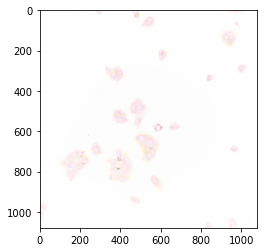

In [20]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
path_df = [img_df['FilePaths'][0], img_df['FilePaths'][1], img_df['FilePaths'][2], img_df['FilePaths'][3]]
c,m,y,k = [ Image.fromarray(cv2.imread(path, cv2.IMREAD_GRAYSCALE)) for path in path_df]
image = Image.merge("CMYK", (c,m,y,k))
plt.imshow(image)

In [21]:
path_df = [img_df['FilePaths'][0], img_df['FilePaths'][1], img_df['FilePaths'][2], img_df['FilePaths'][3]]
c,m,y,k = [ cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in path_df]
image = np.array([np.stack((c, m, y, k), axis=0)])
image

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)

In [22]:
image.shape

(1, 4, 1080, 1080)

In [23]:
data = torch.from_numpy(image).type(torch.float32)
data.shape

torch.Size([1, 4, 1080, 1080])

In [30]:
import torchvision

In [31]:
import torch.nn as nn
import torchvision.models as models


class CNN(nn.Module):
    def __init__(self, num_classes=9, train_net=False):
        super(CNN, self).__init__()
        self.model = models.resnext50_32x4d(pretrained=True)
        if not train_net:
            for param in self.model.parameters():
                param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        layer = self.model.conv1
        new_in_channels = 4
        new_layer = nn.Conv2d(in_channels=new_in_channels,
                              out_channels=layer.out_channels,
                              kernel_size=layer.kernel_size,
                              stride=layer.stride,
                              padding=layer.padding,
                              bias=layer.bias)
        copy_weights = 0
        new_layers_weight = new_layer.weight.clone()
        new_layers_weight[:, :layer.in_channels, :, :] = layer.weight.clone()
        for i in range(new_in_channels - layer.in_channels):
            channel = layer.in_channels + i
            new_layers_weight[:, channel:channel + 1, :, :] = layer.weight[:, copy_weights:copy_weights + 1, ::].clone()
        new_layer.weight = nn.Parameter(new_layers_weight)
        self.model.conv1 = new_layer
#         print(self.model)

    def forward(self, images):
        features = self.model(images)
        return features

In [32]:
model = CNN()
model.load_state_dict(torch.load('../models/resnext50_32x4d.pt', map_location=torch.device('cpu')))
# model.eval()
list(model.children())

[ResNet(
   (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
       (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256

In [33]:
from torchsummary import summary
summary(model, (4, 1080, 1080))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 540, 540]          12,544
       BatchNorm2d-2         [-1, 64, 540, 540]             128
              ReLU-3         [-1, 64, 540, 540]               0
         MaxPool2d-4         [-1, 64, 270, 270]               0
            Conv2d-5        [-1, 128, 270, 270]           8,192
       BatchNorm2d-6        [-1, 128, 270, 270]             256
              ReLU-7        [-1, 128, 270, 270]               0
            Conv2d-8        [-1, 128, 270, 270]           4,608
       BatchNorm2d-9        [-1, 128, 270, 270]             256
             ReLU-10        [-1, 128, 270, 270]               0
           Conv2d-11        [-1, 256, 270, 270]          32,768
      BatchNorm2d-12        [-1, 256, 270, 270]             512
           Conv2d-13        [-1, 256, 270, 270]          16,384
      BatchNorm2d-14        [-1, 256, 2

Total params: 23,001,481
Trainable params: 30,985
Non-trainable params: 22,970,496
----------------------------------------------------------------
Input size (MB): 17.80
Forward/backward pass size (MB): 8439.27
Params size (MB): 87.74
Estimated Total Size (MB): 8544.82
----------------------------------------------------------------


In [34]:
out = model(data)

In [35]:
out

tensor([[-0.4198, -0.7056,  1.7257, -0.9195, -1.0963,  0.8104,  0.8898, -0.4654,
         -0.7947]], grad_fn=<AddmmBackward0>)

In [39]:
model.model.fc

Linear(in_features=2048, out_features=9, bias=True)

#  Cutting


In [40]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [41]:
model.model.fc = Identity()
# x = torch.randn(1, 4, 1080, 1080)
out = model(data)

In [42]:
model

CNN(
  (model): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [44]:
out.shape

torch.Size([1, 2048])

In [32]:
model.classifier = nn.Sequential(*list(model.classifier.children()))
print(model.classifier)

AttributeError: 'CNN' object has no attribute 'classifier'